# 462 Final Project - SeeFish app dataset preparation

## 1. Image scraping from Internet

Search and download images to complement the origanl dataset. Will get a number of images for each class up to the number of images desired (in this case 150) so the final dataset will have balanced classes.

### Packages import

In [5]:
import selenium
import time
import requests
import io
import os
import PIL
import hashlib

from PIL import Image
from selenium import webdriver

### Functions definiton

In [ ]:
#### image search and download

def fetch_image_urls(query:str, max_links_to_fetch:int, wd:webdriver, sleep_between_interactions:int=1):
    def scroll_to_end(wd):
        wd.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(sleep_between_interactions)    
    
    # build the google query
    search_url = "https://www.google.com/search?safe=off&site=&tbm=isch&source=hp&q={q}&oq={q}&gs_l=img"

    # load the page
    wd.get(search_url.format(q=query))

    image_urls = set()
    image_count = 0
    results_start = 0
    while image_count < max_links_to_fetch:
        scroll_to_end(wd)

        # get all image thumbnail results
        thumbnail_results = wd.find_elements_by_css_selector("img.Q4LuWd")
        number_results = len(thumbnail_results)
        
        print(f"Found: {number_results} search results. Extracting links from {results_start}:{number_results}")
        
        for img in thumbnail_results[results_start:number_results]:
            # try to click every thumbnail such that we can get the real image behind it
            try:
                img.click()
                time.sleep(sleep_between_interactions)
            except Exception:
                continue

            # extract image urls    
            actual_images = wd.find_elements_by_css_selector('img.n3VNCb')
            for actual_image in actual_images:
                if actual_image.get_attribute('src') and 'http' in actual_image.get_attribute('src'):
                    image_urls.add(actual_image.get_attribute('src'))

            image_count = len(image_urls)

            if len(image_urls) >= max_links_to_fetch:
                print(f"Found: {len(image_urls)} image links, done!")
                break
        else:
            print("Found:", len(image_urls), "image links, looking for more ...")
            time.sleep(30)
            return
            load_more_button = wd.find_element_by_css_selector(".mye4qd")
            if load_more_button:
                wd.execute_script("document.querySelector('.mye4qd').click();")

        # move the result startpoint further down
        results_start = len(thumbnail_results)

    return image_urls


def persist_image(folder_path:str,url:str):
    try:
        image_content = requests.get(url).content

    except Exception as e:
        print(f"ERROR - Could not download {url} - {e}")

    try:
        image_file = io.BytesIO(image_content)
        image = Image.open(image_file).convert('RGB')
        file_path = os.path.join(folder_path,hashlib.sha1(image_content).hexdigest()[:10] + '.jpg')
        with open(file_path, 'wb') as f:
            image.save(f, "JPEG", quality=85)
        print(f"SUCCESS - saved {url} - as {file_path}")
    except Exception as e:
        print(f"ERROR - Could not save {url} - {e}")
        
def search_and_download(search_term:str,driver_path:str,number_images:int,target_path='./images'):
    target_folder = os.path.join(target_path,'_'.join(search_term.lower().split(' ')))

    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    with webdriver.Chrome(executable_path=driver_path) as wd:
        res = fetch_image_urls(search_term, number_images, wd=wd, sleep_between_interactions=0.5)
    
    if res:    
        for elem in res:
            persist_image(target_folder,elem)

def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

### Search and download up to 150 images for classes

In [ ]:
DRIVER_PATH = '/Users/vittoriopro/MSDS/462/FinalProject/scraper/chromedriver'
dir_path1 = '/Users/vittoriopro/MSDS/462/FinalProject/Datasets/WildFish/WildFish_Trop_scrape'

NUM_FILES_GEN = 150
data_folders1 = list(listdir_nohidden(dir_path1))
#plt.hist(lenghts1, density=True, bins=20)
folders_dict = dict(zip(data_folders1, data_folders1))

start = time.time()

for (i, folder_path) in folders_dict.items():
    fold = os.listdir(os.path.join(dir_path1,folder_path))
    search_term = folder_path
    num_files = len(fold)
    num_files_desired = (NUM_FILES_GEN-num_files)

    search_and_download(
        search_term=search_term,
        driver_path=DRIVER_PATH,
        number_images=num_files_desired)
       
end = time.time()

print(end - start)

### Merge the original dataset with the donloaded images

In [ ]:
import subprocess as sbp
import os

input_dir = '/Users/vittoriopro/MSDS/462/FinalProject/Datasets/WildFish/scraped_images/images'
output_dir = '/Users/vittoriopro/MSDS/462/FinalProject/Datasets/WildFish/WildFish_Trop_scrape_2_0'

for (i, folder_path) in folders_dict.items():
    path= os.path.join(input_dir,folder_path)
    fol = os.listdir(path)
    p2 = os.path.join(output_dir,folder_path)
    
    for j in fol:
        p1 = os.path.join(path,j)
        p3 = 'cp -r ' + p1 +' ' + p2+'/.'
        sbp.Popen(p3,shell=True)

## 2. Create training, validation and test set

### Packages import

In [60]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import splitfolders  # or import split_folders

import random
from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import util
from skimage import io

### Functions definiton

In [61]:
def random_rotation(image_array: ndarray):
    # pick a random degree of rotation between 25% on the left and 25% on the right
    random_degree = random.uniform(-25, 25)
    return sk.transform.rotate(image_array, random_degree)

def random_noise(image_array: ndarray):
    # add random noise to the image
    return sk.util.random_noise(image_array)

def horizontal_flip(image_array: ndarray):
    # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
    return image_array[:, ::-1]

def vertical_flip(image_array: ndarray):
    # vertical flip doesn't need skimage, it's easy as flipping the image array of pixels !
    return image_array[::-1, :]

def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

Create validation and test dataset containing 20 images for each class. 

In [40]:
dir_path_input = '/Users/vittoriopro/MSDS/462/FinalProject/Datasets/WildFish/WildFish_Trop_scrape/'

dir_path_output = '/Users/vittoriopro/MSDS/462/FinalProject/Datasets/WildFish/WildFish_Tropical_Split_2_0/'


# Split val/test with a fixed number of items e.g. 100 for each set.
# To only split into training and validation set, use a single number to `fixed`, i.e., `10`.

splitfolders.fixed(dir_path_input, output=dir_path_output, seed=1234, fixed=(20,20), oversample=False, group_prefix=None) # default values'



Copying files: 0 files [00:00, ? files/s]
Copying files: 1 files [00:00,  5.57 files/s]
Copying files: 73 files [00:00,  7.93 files/s]
Copying files: 170 files [00:00, 11.29 files/s]
Copying files: 263 files [00:00, 16.05 files/s]
Copying files: 362 files [00:00, 22.76 files/s]
Copying files: 481 files [00:00, 32.25 files/s]
Copying files: 604 files [00:00, 45.56 files/s]
Copying files: 740 files [00:00, 64.16 files/s]
Copying files: 855 files [00:00, 89.51 files/s]
Copying files: 966 files [00:01, 122.70 files/s]
Copying files: 1072 files [00:01, 166.91 files/s]
Copying files: 1181 files [00:01, 223.67 files/s]
Copying files: 1290 files [00:01, 293.60 files/s]
Copying files: 1397 files [00:01, 374.01 files/s]
Copying files: 1507 files [00:01, 465.06 files/s]
Copying files: 1614 files [00:01, 520.59 files/s]
Copying files: 1711 files [00:01, 533.36 files/s]
Copying files: 1808 files [00:02, 615.51 files/s]
Copying files: 1896 files [00:02, 674.71 files/s]
Copying files: 2002 files [00

Copying files: 27911 files [00:33, 897.35 files/s]
Copying files: 28004 files [00:33, 874.84 files/s]
Copying files: 28094 files [00:34, 873.08 files/s]
Copying files: 28203 files [00:34, 926.92 files/s]
Copying files: 28314 files [00:34, 972.83 files/s]
Copying files: 28417 files [00:34, 988.87 files/s]
Copying files: 28519 files [00:34, 996.96 files/s]
Copying files: 28621 files [00:34, 1000.70 files/s]
Copying files: 28738 files [00:34, 1043.31 files/s]
Copying files: 28857 files [00:34, 1082.51 files/s]
Copying files: 28970 files [00:34, 1095.09 files/s]
Copying files: 29081 files [00:35, 1026.21 files/s]
Copying files: 29191 files [00:35, 1045.41 files/s]
Copying files: 29297 files [00:35, 939.64 files/s] 
Copying files: 29394 files [00:35, 940.23 files/s]
Copying files: 29490 files [00:35, 910.91 files/s]
Copying files: 29593 files [00:35, 937.38 files/s]
Copying files: 29689 files [00:35, 903.30 files/s]
Copying files: 29781 files [00:35, 774.34 files/s]
Copying files: 29863 fil

Copying files: 54973 files [01:07, 828.23 files/s]
Copying files: 55059 files [01:07, 827.22 files/s]
Copying files: 55150 files [01:07, 850.13 files/s]
Copying files: 55246 files [01:07, 879.59 files/s]
Copying files: 55336 files [01:08, 880.28 files/s]
Copying files: 55425 files [01:08, 861.25 files/s]
Copying files: 55513 files [01:08, 857.95 files/s]
Copying files: 55600 files [01:08, 813.66 files/s]
Copying files: 55683 files [01:08, 708.06 files/s]
Copying files: 55757 files [01:08, 583.65 files/s]
Copying files: 55836 files [01:08, 632.07 files/s]
Copying files: 55910 files [01:08, 659.52 files/s]
Copying files: 55990 files [01:09, 695.79 files/s]
Copying files: 56103 files [01:09, 785.79 files/s]
Copying files: 56188 files [01:09, 666.04 files/s]
Copying files: 56263 files [01:09, 661.74 files/s]
Copying files: 56342 files [01:09, 694.92 files/s]
Copying files: 56418 files [01:09, 710.48 files/s]
Copying files: 56501 files [01:09, 741.63 files/s]
Copying files: 56582 files [01:

The remaing images will belong to the training set

(array([0.1, 0.1, 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0.1,
        0. , 0. , 0. , 0.1, 0.1, 0. , 0.3]),
 array([29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
        42., 43., 44., 45., 46., 47., 48., 49.]),
 <BarContainer object of 20 artists>)

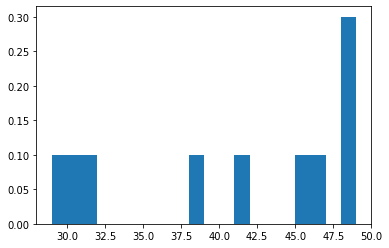

In [51]:
dir_path1 = '/Users/vittoriopro/MSDS/462/FinalProject/Datasets/WildFish/WildFish_Tropical_Split_2_0/train'

os.chdir(dir_path1)

data_folders1 = list(listdir_nohidden(dir_path1))

filenames1 = [os.listdir(f) for f in data_folders1]

lenghts1 = [len(f) for f in filenames1]

files_dict1 = dict(zip(data_folders1, filenames1))

lengh_dict = dict(zip(data_folders1,lenghts1))

folders_dict = dict(zip(data_folders1, data_folders1))

plt.hist(lenghts1, density=True, bins=20)

## 3. Data augumentation

The training dataset is increased adding augumented images up to 200 images for class.

In [52]:

########### Create random images for training

NUM_FILES_GEN = 200

start = time.time()

for (i, folder_path) in folders_dict.items():
# our folder path containing some images
#folder_path = '/Users/vittoriopro/Documents/AI/MSDS/462/FinalProject/Datasets/WildFish/WildFish_Tropical_Bal/Abactochromis_labrosus'
# the number of file to generate
    fold = os.listdir(os.path.join(dir_path1,folder_path))
    num_files_desired = (NUM_FILES_GEN-len(fold))

# loop on all files of the folder and build a list of files paths
#    images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
#    images.remove('*/.DS_Store')
    images = [os.path.join(folder_path, f) for f in list(listdir_nohidden(folder_path)) if os.path.isfile(os.path.join(folder_path, f))]
# dictionary of the transformations functions we defined earlier
    available_transformations = {
        'rotate': random_rotation,
        'horizontal_flip': horizontal_flip,
        'noise': random_noise
    #    'vertical_flip': vertical_flip,

    }


    num_generated_files = 0
    while num_generated_files <= num_files_desired:
        # random image from the folder
        image_path = random.choice(images)
        print(image_path)
        # read image as an two dimensional array of pixels
        image_to_transform = sk.io.imread(image_path)
        image_to_transform = image_to_transform[:,:,:3]
        # random num of transformation to apply
        num_transformations_to_apply = random.randint(1, len(available_transformations))
    
        num_transformations = 0
        transformed_image = None
        while num_transformations <= num_transformations_to_apply:
            # random transformation to apply for a single image
            key = random.choice(list(available_transformations))
            transformed_image = available_transformations[key](image_to_transform)
            num_transformations += 1
    
            new_file_path = '%s/augmented_image_%s.jpg' % (folder_path, num_generated_files)
    
            # write image to the disk
            
            transformed_image = sk.img_as_ubyte(transformed_image)
            io.imsave(new_file_path, transformed_image)
        num_generated_files += 1
    
end = time.time()
print(end - start)

Pomacanthus_paru/Pomacanthus_paru_0113.jpg
Pomacanthus_paru/Pomacanthus_paru_0050.jpg
Pomacanthus_paru/Pomacanthus_paru_0057.jpg
Pomacanthus_paru/Pomacanthus_paru_0110.jpg
Pomacanthus_paru/Pomacanthus_paru_0015.jpg
Pomacanthus_paru/Pomacanthus_paru_0016.jpg
Pomacanthus_paru/Pomacanthus_paru_0020.jpg
Pomacanthus_paru/Pomacanthus_paru_0006.jpg
Pomacanthus_paru/Pomacanthus_paru_0125.jpg
Pomacanthus_paru/Pomacanthus_paru_0063.jpg
Pomacanthus_paru/Pomacanthus_paru_0027.jpg
Pomacanthus_paru/Pomacanthus_paru_0016.jpg
Pomacanthus_paru/Pomacanthus_paru_0083.jpg
Pomacanthus_paru/Pomacanthus_paru_0051.jpg
Pomacanthus_paru/Pomacanthus_paru_0080.jpg
Pomacanthus_paru/Pomacanthus_paru_0051.jpg
Pomacanthus_paru/Pomacanthus_paru_0006.jpg
Pomacanthus_paru/Pomacanthus_paru_0115.jpg
Pomacanthus_paru/Pomacanthus_paru_0016.jpg
Pomacanthus_paru/Pomacanthus_paru_0027.jpg
Pomacanthus_paru/Pomacanthus_paru_0015.jpg
Pomacanthus_paru/Pomacanthus_paru_0125.jpg
Pomacanthus_paru/Pomacanthus_paru_0006.jpg
Pomacanthus

Pomacanthus_paru/Pomacanthus_paru_0125.jpg
Pomacanthus_paru/Pomacanthus_paru_0028.jpg
Pomacanthus_paru/Pomacanthus_paru_0095.jpg
Pomacanthus_paru/Pomacanthus_paru_0040.jpg
Pomacanthus_paru/Pomacanthus_paru_0016.jpg
Pomacanthus_paru/Pomacanthus_paru_0080.jpg
Pomacanthus_paru/Pomacanthus_paru_0118.jpg
Pomacanthus_paru/Pomacanthus_paru_0084.jpg
Pomacanthus_paru/Pomacanthus_paru_0068.jpg
Pomacanthus_paru/Pomacanthus_paru_0006.jpg
Pomacanthus_paru/Pomacanthus_paru_0083.jpg
Pomacanthus_paru/Pomacanthus_paru_0006.jpg
Pomacanthus_paru/Pomacanthus_paru_0051.jpg
Pomacanthus_paru/Pomacanthus_paru_0020.jpg
Pomacanthus_paru/Pomacanthus_paru_0027.jpg
Pomacanthus_paru/Pomacanthus_paru_0113.jpg
Pomacanthus_paru/Pomacanthus_paru_0053.jpg
Pomacanthus_paru/Pomacanthus_paru_0055.jpg
Pomacanthus_paru/Pomacanthus_paru_0032.jpg
Pomacanthus_paru/Pomacanthus_paru_0125.jpg
Pomacanthus_paru/Pomacanthus_paru_0027.jpg
Pomacanthus_paru/Pomacanthus_paru_0110.jpg
Pomacanthus_paru/Pomacanthus_paru_0039.jpg
Pomacanthus

Pomacanthus_paru/Pomacanthus_paru_0095.jpg
Pomacanthus_paru/Pomacanthus_paru_0051.jpg
Pomacanthus_paru/Pomacanthus_paru_0053.jpg
Pomacanthus_paru/Pomacanthus_paru_0006.jpg
Pomacanthus_paru/Pomacanthus_paru_0016.jpg
Pomacanthus_paru/Pomacanthus_paru_0027.jpg
Pomacanthus_paru/Pomacanthus_paru_0039.jpg
Pomacanthus_paru/Pomacanthus_paru_0036.jpg
Pomacanthus_paru/Pomacanthus_paru_0053.jpg
Pomacanthus_paru/Pomacanthus_paru_0006.jpg
Pomacanthus_paru/Pomacanthus_paru_0043.jpg
Pomacanthus_paru/Pomacanthus_paru_0006.jpg
Pomacanthus_paru/Pomacanthus_paru_0016.jpg
Pomacanthus_paru/Pomacanthus_paru_0068.jpg
Pomacanthus_paru/Pomacanthus_paru_0040.jpg
Pomacanthus_paru/Pomacanthus_paru_0113.jpg
Pomacanthus_paru/Pomacanthus_paru_0095.jpg
Pomacanthus_paru/Pomacanthus_paru_0068.jpg
Pomacanthus_paru/Pomacanthus_paru_0066.jpg
Pomacanthus_paru/Pomacanthus_paru_0051.jpg
Pomacanthus_paru/Pomacanthus_paru_0028.jpg
Pomacanthus_paru/Pomacanthus_paru_0039.jpg
Pomacanthus_paru/Pomacanthus_paru_0039.jpg
Pomacanthus

Acanthurus_coeruleus/Acanthurus_coeruleus_0032.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0056.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0106.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0075.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0028.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0077.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0028.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0080.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0016.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0006.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0106.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0027.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0027.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0028.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0090.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0080.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0039.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0097.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0039.jpg
Acanthurus_coeruleus/Acanthurus

Acanthurus_coeruleus/Acanthurus_coeruleus_0072.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0121.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0050.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0006.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0075.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0072.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0039.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0054.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0055.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0097.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0021.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0027.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0028.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0046.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0106.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0032.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0016.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0097.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0050.jpg
Acanthurus_coeruleus/Acanthurus

Acanthurus_coeruleus/Acanthurus_coeruleus_0006.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0036.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0115.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0121.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0099.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0050.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0020.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0055.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0072.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0036.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0072.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0021.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0090.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0046.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0099.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0072.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0072.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0077.jpg
Acanthurus_coeruleus/Acanthurus_coeruleus_0028.jpg
Acanthurus_coeruleus/Acanthurus

Cotylorhiza_tuberculata/teuberculata2_IMG_00006.jpg
Cotylorhiza_tuberculata/teuberculata7_IMG_00005.jpg
Cotylorhiza_tuberculata/teuberculata10_IMG_00021.jpg
Cotylorhiza_tuberculata/teuberculata3_IMG_00010.jpg
Cotylorhiza_tuberculata/teuberculata1_IMG_00685.jpg
Cotylorhiza_tuberculata/teuberculata3_IMG_00014.jpg
Cotylorhiza_tuberculata/teuberculata3_IMG_00014.jpg
Cotylorhiza_tuberculata/teuberculata7_IMG_00011.jpg
Cotylorhiza_tuberculata/teuberculata10_IMG_00023.jpg
Cotylorhiza_tuberculata/teuberculata8_IMG_00009.jpg
Cotylorhiza_tuberculata/teuberculata4_IMG_00009.jpg
Cotylorhiza_tuberculata/teuberculata8_IMG_00007.jpg
Cotylorhiza_tuberculata/teuberculata3_IMG_00005.jpg
Cotylorhiza_tuberculata/teuberculata10_IMG_00019.jpg
Cotylorhiza_tuberculata/teuberculata7_IMG_00006.jpg
Cotylorhiza_tuberculata/teuberculata9_IMG_00005.jpg
Cotylorhiza_tuberculata/teuberculata6_IMG_00010.jpg
Cotylorhiza_tuberculata/teuberculata2_IMG_00006.jpg
Cotylorhiza_tuberculata/teuberculata10_IMG_00021.jpg
Cotylorh

Cotylorhiza_tuberculata/teuberculata6_IMG_00004.jpg
Cotylorhiza_tuberculata/teuberculata2_IMG_00014.jpg
Cotylorhiza_tuberculata/teuberculata10_IMG_00037.jpg
Cotylorhiza_tuberculata/teuberculata10_IMG_00034.jpg
Cotylorhiza_tuberculata/teuberculata8_IMG_00004.jpg
Cotylorhiza_tuberculata/teuberculata4_IMG_00009.jpg
Cotylorhiza_tuberculata/teuberculata7_IMG_00013.jpg
Cotylorhiza_tuberculata/teuberculata10_IMG_00021.jpg
Cotylorhiza_tuberculata/teuberculata1_IMG_00104.jpg
Cotylorhiza_tuberculata/teuberculata5_IMG_00009.jpg
Cotylorhiza_tuberculata/teuberculata7_IMG_00011.jpg
Cotylorhiza_tuberculata/teuberculata7_IMG_00006.jpg
Cotylorhiza_tuberculata/teuberculata10_IMG_00023.jpg
Cotylorhiza_tuberculata/teuberculata6_IMG_00010.jpg
Cotylorhiza_tuberculata/teuberculata2_IMG_00013.jpg
Cotylorhiza_tuberculata/teuberculata10_IMG_00034.jpg
Cotylorhiza_tuberculata/teuberculata10_IMG_00032.jpg
Cotylorhiza_tuberculata/teuberculata7_IMG_00005.jpg
Cotylorhiza_tuberculata/teuberculata3_IMG_00010.jpg
Cotylo

Cotylorhiza_tuberculata/teuberculata5_IMG_00009.jpg
Cotylorhiza_tuberculata/teuberculata4_IMG_00008.jpg
Cotylorhiza_tuberculata/teuberculata7_IMG_00005.jpg
Cotylorhiza_tuberculata/teuberculata8_IMG_00007.jpg
Cotylorhiza_tuberculata/teuberculata2_IMG_00010.jpg
Cotylorhiza_tuberculata/teuberculata8_IMG_00004.jpg
Cotylorhiza_tuberculata/teuberculata7_IMG_00005.jpg
Cotylorhiza_tuberculata/teuberculata1_IMG_00685.jpg
Cotylorhiza_tuberculata/teuberculata8_IMG_00007.jpg
Cotylorhiza_tuberculata/teuberculata7_IMG_00011.jpg
Cotylorhiza_tuberculata/teuberculata2_IMG_00014.jpg
Cotylorhiza_tuberculata/teuberculata4_IMG_00009.jpg
Cotylorhiza_tuberculata/teuberculata10_IMG_00034.jpg
Cotylorhiza_tuberculata/teuberculata2_IMG_00015.jpg
Cotylorhiza_tuberculata/teuberculata10_IMG_00016.jpg
Cotylorhiza_tuberculata/teuberculata9_IMG_00005.jpg
Cotylorhiza_tuberculata/teuberculata8_IMG_00004.jpg
Cotylorhiza_tuberculata/teuberculata7_IMG_00009.jpg
Cotylorhiza_tuberculata/teuberculata10_IMG_00021.jpg
Cotylorhi

Diodon_holocanthus/Diodon_holocanthus_0020.jpg
Diodon_holocanthus/Diodon_holocanthus_0117.jpg
Diodon_holocanthus/Diodon_holocanthus_0027.jpg
Diodon_holocanthus/Diodon_holocanthus_0114.jpg
Diodon_holocanthus/Diodon_holocanthus_0109.jpg
Diodon_holocanthus/Diodon_holocanthus_0077.jpg
Diodon_holocanthus/Diodon_holocanthus_0092.jpg
Diodon_holocanthus/Diodon_holocanthus_0101.jpg
Diodon_holocanthus/Diodon_holocanthus_0101.jpg
Diodon_holocanthus/Diodon_holocanthus_0111.jpg
Diodon_holocanthus/Diodon_holocanthus_0056.jpg
Diodon_holocanthus/Diodon_holocanthus_0073.jpg
Diodon_holocanthus/Diodon_holocanthus_0050.jpg
Diodon_holocanthus/Diodon_holocanthus_0039.jpg
Diodon_holocanthus/Diodon_holocanthus_0077.jpg
Diodon_holocanthus/Diodon_holocanthus_0027.jpg
Diodon_holocanthus/Diodon_holocanthus_0101.jpg
Diodon_holocanthus/Diodon_holocanthus_0117.jpg
Diodon_holocanthus/Diodon_holocanthus_0099.jpg
Diodon_holocanthus/Diodon_holocanthus_0111.jpg
Diodon_holocanthus/Diodon_holocanthus_0107.jpg
Diodon_holoca

Diodon_holocanthus/Diodon_holocanthus_0117.jpg
Diodon_holocanthus/Diodon_holocanthus_0020.jpg
Diodon_holocanthus/Diodon_holocanthus_0063.jpg
Diodon_holocanthus/Diodon_holocanthus_0130.jpg
Diodon_holocanthus/Diodon_holocanthus_0097.jpg
Diodon_holocanthus/Diodon_holocanthus_0040.jpg
Diodon_holocanthus/Diodon_holocanthus_0097.jpg
Diodon_holocanthus/Diodon_holocanthus_0093.jpg
Diodon_holocanthus/Diodon_holocanthus_0081.jpg
Diodon_holocanthus/Diodon_holocanthus_0056.jpg
Diodon_holocanthus/Diodon_holocanthus_0054.jpg
Diodon_holocanthus/Diodon_holocanthus_0081.jpg
Diodon_holocanthus/Diodon_holocanthus_0093.jpg
Diodon_holocanthus/Diodon_holocanthus_0109.jpg
Diodon_holocanthus/Diodon_holocanthus_0081.jpg
Diodon_holocanthus/Diodon_holocanthus_0020.jpg
Diodon_holocanthus/Diodon_holocanthus_0040.jpg
Diodon_holocanthus/Diodon_holocanthus_0107.jpg
Diodon_holocanthus/Diodon_holocanthus_0027.jpg
Diodon_holocanthus/Diodon_holocanthus_0020.jpg
Diodon_holocanthus/Diodon_holocanthus_0101.jpg
Diodon_holoca

Rhincodon_typus/Rhincodon_typus_0077.jpg
Rhincodon_typus/Rhincodon_typus_0028.jpg
Rhincodon_typus/Rhincodon_typus_0010.jpg
Rhincodon_typus/Rhincodon_typus_0043.jpg
Rhincodon_typus/Rhincodon_typus_0100.jpg
Rhincodon_typus/Rhincodon_typus_0070.jpg
Rhincodon_typus/Rhincodon_typus_0130.jpg
Rhincodon_typus/Rhincodon_typus_0081.jpg
Rhincodon_typus/Rhincodon_typus_0035.jpg
Rhincodon_typus/Rhincodon_typus_0028.jpg
Rhincodon_typus/Rhincodon_typus_0092.jpg
Rhincodon_typus/Rhincodon_typus_0047.jpg
Rhincodon_typus/Rhincodon_typus_0087.jpg
Rhincodon_typus/Rhincodon_typus_0057.jpg
Rhincodon_typus/Rhincodon_typus_0041.jpg
Rhincodon_typus/Rhincodon_typus_0041.jpg
Rhincodon_typus/Rhincodon_typus_0066.jpg
Rhincodon_typus/Rhincodon_typus_0122.jpg
Rhincodon_typus/Rhincodon_typus_0089.jpg
Rhincodon_typus/Rhincodon_typus_0070.jpg
Rhincodon_typus/Rhincodon_typus_0035.jpg
Rhincodon_typus/Rhincodon_typus_0056.jpg
Rhincodon_typus/Rhincodon_typus_0066.jpg
Rhincodon_typus/Rhincodon_typus_0046.jpg
Rhincodon_typus/

Rhincodon_typus/Rhincodon_typus_0041.jpg
Rhincodon_typus/Rhincodon_typus_0047.jpg
Rhincodon_typus/Rhincodon_typus_0081.jpg
Rhincodon_typus/Rhincodon_typus_0056.jpg
Rhincodon_typus/Rhincodon_typus_0098.jpg
Rhincodon_typus/Rhincodon_typus_0066.jpg
Rhincodon_typus/Rhincodon_typus_0079.jpg
Rhincodon_typus/Rhincodon_typus_0057.jpg
Rhincodon_typus/Rhincodon_typus_0057.jpg
Rhincodon_typus/Rhincodon_typus_0040.jpg
Rhincodon_typus/Rhincodon_typus_0095.jpg
Rhincodon_typus/Rhincodon_typus_0013.jpg
Rhincodon_typus/Rhincodon_typus_0053.jpg
Rhincodon_typus/Rhincodon_typus_0118.jpg
Rhincodon_typus/Rhincodon_typus_0052.jpg
Rhincodon_typus/Rhincodon_typus_0016.jpg
Rhincodon_typus/Rhincodon_typus_0033.jpg
Rhincodon_typus/Rhincodon_typus_0129.jpg
Rhincodon_typus/Rhincodon_typus_0032.jpg
Rhincodon_typus/Rhincodon_typus_0047.jpg
Rhincodon_typus/Rhincodon_typus_0116.jpg
Rhincodon_typus/Rhincodon_typus_0010.jpg
Rhincodon_typus/Rhincodon_typus_0130.jpg
Rhincodon_typus/Rhincodon_typus_0100.jpg
Rhincodon_typus/

Rhincodon_typus/Rhincodon_typus_0040.jpg
Rhincodon_typus/Rhincodon_typus_0047.jpg
Rhincodon_typus/Rhincodon_typus_0054.jpg
Rhincodon_typus/Rhincodon_typus_0129.jpg
Rhincodon_typus/Rhincodon_typus_0098.jpg
Rhincodon_typus/Rhincodon_typus_0016.jpg
Rhincodon_typus/Rhincodon_typus_0013.jpg
Rhincodon_typus/Rhincodon_typus_0098.jpg
Rhincodon_typus/Rhincodon_typus_0129.jpg
Rhincodon_typus/Rhincodon_typus_0116.jpg
Rhincodon_typus/Rhincodon_typus_0054.jpg
Rhincodon_typus/Rhincodon_typus_0015.jpg
Rhincodon_typus/Rhincodon_typus_0070.jpg
Rhincodon_typus/Rhincodon_typus_0096.jpg
Rhincodon_typus/Rhincodon_typus_0013.jpg
Rhincodon_typus/Rhincodon_typus_0095.jpg
Rhincodon_typus/Rhincodon_typus_0116.jpg
Rhincodon_typus/Rhincodon_typus_0016.jpg
Rhincodon_typus/Rhincodon_typus_0046.jpg
Rhincodon_typus/Rhincodon_typus_0119.jpg
Rhincodon_typus/Rhincodon_typus_0130.jpg
Rhincodon_typus/Rhincodon_typus_0066.jpg
Rhincodon_typus/Rhincodon_typus_0053.jpg
Rhincodon_typus/Rhincodon_typus_0032.jpg
Rhincodon_typus/

Rhizostoma_pulmo/pulmo7_IMG_00014.jpg
Rhizostoma_pulmo/pulmo5_IMG_00030.jpg
Rhizostoma_pulmo/pulmo11_IMG_00008.jpg
Rhizostoma_pulmo/pulmo11_IMG_00009.jpg
Rhizostoma_pulmo/pulmo1_IMG_00008.jpg
Rhizostoma_pulmo/pulmo5_IMG_00006.jpg
Rhizostoma_pulmo/pulmo5_IMG_00014.jpg
Rhizostoma_pulmo/pulmo2_IMG_00008.jpg
Rhizostoma_pulmo/pulmo5_IMG_00030.jpg
Rhizostoma_pulmo/pulmo12_IMG_00002.jpg
Rhizostoma_pulmo/pulmo2_IMG_00013.jpg
Rhizostoma_pulmo/pulmo3_IMG_00010.jpg
Rhizostoma_pulmo/pulmo5_IMG_00007.jpg
Rhizostoma_pulmo/pulmo15_IMG_00004.jpg
Rhizostoma_pulmo/pulmo13_IMG_00012.jpg
Rhizostoma_pulmo/pulmo11_IMG_00009.jpg
Rhizostoma_pulmo/pulmo2_IMG_00008.jpg
Rhizostoma_pulmo/pulmo9_IMG_00005.jpg
Rhizostoma_pulmo/pulmo15_IMG_00003.jpg
Rhizostoma_pulmo/pulmo15_IMG_00003.jpg
Rhizostoma_pulmo/pulmo12_IMG_00002.jpg
Rhizostoma_pulmo/pulmo13_IMG_00005.jpg
Rhizostoma_pulmo/pulmo6_IMG_00006.jpg
Rhizostoma_pulmo/pulmo7_IMG_00014.jpg
Rhizostoma_pulmo/pulmo5_IMG_00014.jpg
Rhizostoma_pulmo/pulmo2_IMG_00013.jpg
Rh

Rhizostoma_pulmo/pulmo2_IMG_00013.jpg
Rhizostoma_pulmo/pulmo1_IMG_00020.jpg
Rhizostoma_pulmo/pulmo13_IMG_00005.jpg
Rhizostoma_pulmo/pulmo6_IMG_00004.jpg
Rhizostoma_pulmo/pulmo5_IMG_00015.jpg
Rhizostoma_pulmo/pulmo1_IMG_00012.jpg
Rhizostoma_pulmo/pulmo2_IMG_00004.jpg
Rhizostoma_pulmo/pulmo3_IMG_00009.jpg
Rhizostoma_pulmo/pulmo12_IMG_00001.jpg
Rhizostoma_pulmo/pulmo14_IMG_00007.jpg
Rhizostoma_pulmo/pulmo5_IMG_00006.jpg
Rhizostoma_pulmo/pulmo8_IMG_00006.jpg
Rhizostoma_pulmo/pulmo3_IMG_00009.jpg
Rhizostoma_pulmo/pulmo8_IMG_00007.jpg
Rhizostoma_pulmo/pulmo14_IMG_00007.jpg
Rhizostoma_pulmo/pulmo11_IMG_00004.jpg
Rhizostoma_pulmo/pulmo5_IMG_00006.jpg
Rhizostoma_pulmo/pulmo13_IMG_00001.jpg
Rhizostoma_pulmo/pulmo3_IMG_00010.jpg
Rhizostoma_pulmo/pulmo11_IMG_00004.jpg
Rhizostoma_pulmo/pulmo15_IMG_00004.jpg
Rhizostoma_pulmo/pulmo5_IMG_00018.jpg
Rhizostoma_pulmo/pulmo1_IMG_00015.jpg
Rhizostoma_pulmo/pulmo11_IMG_00008.jpg
Rhizostoma_pulmo/pulmo7_IMG_00013.jpg
Rhizostoma_pulmo/pulmo8_IMG_00007.jpg
Rhi

Aluterus_scriptus/Aluterus_scriptus_0073.jpg
Aluterus_scriptus/Aluterus_scriptus_0129.jpg
Aluterus_scriptus/Aluterus_scriptus_0135.jpg
Aluterus_scriptus/Aluterus_scriptus_0098.jpg
Aluterus_scriptus/Aluterus_scriptus_0057.jpg
Aluterus_scriptus/Aluterus_scriptus_0132.jpg
Aluterus_scriptus/Aluterus_scriptus_0079.jpg
Aluterus_scriptus/Aluterus_scriptus_0092.jpg
Aluterus_scriptus/Aluterus_scriptus_0057.jpg
Aluterus_scriptus/Aluterus_scriptus_0089.jpg
Aluterus_scriptus/Aluterus_scriptus_0110.jpg
Aluterus_scriptus/Aluterus_scriptus_0092.jpg
Aluterus_scriptus/Aluterus_scriptus_0043.jpg
Aluterus_scriptus/Aluterus_scriptus_0132.jpg
Aluterus_scriptus/Aluterus_scriptus_0131.jpg
Aluterus_scriptus/Aluterus_scriptus_0103.jpg
Aluterus_scriptus/Aluterus_scriptus_0057.jpg
Aluterus_scriptus/Aluterus_scriptus_0124.jpg
Aluterus_scriptus/Aluterus_scriptus_0110.jpg
Aluterus_scriptus/Aluterus_scriptus_0098.jpg
Aluterus_scriptus/Aluterus_scriptus_0068.jpg
Aluterus_scriptus/Aluterus_scriptus_0092.jpg
Aluterus_s

Aluterus_scriptus/Aluterus_scriptus_0015.jpg
Aluterus_scriptus/Aluterus_scriptus_0073.jpg
Aluterus_scriptus/Aluterus_scriptus_0041.jpg
Aluterus_scriptus/Aluterus_scriptus_0072.jpg
Aluterus_scriptus/Aluterus_scriptus_0010.jpg
Aluterus_scriptus/Aluterus_scriptus_0072.jpg
Aluterus_scriptus/Aluterus_scriptus_0073.jpg
Aluterus_scriptus/Aluterus_scriptus_0033.jpg
Aluterus_scriptus/Aluterus_scriptus_0079.jpg
Aluterus_scriptus/Aluterus_scriptus_0097.jpg
Aluterus_scriptus/Aluterus_scriptus_0013.jpg
Aluterus_scriptus/Aluterus_scriptus_0135.jpg
Aluterus_scriptus/Aluterus_scriptus_0052.jpg
Aluterus_scriptus/Aluterus_scriptus_0089.jpg
Aluterus_scriptus/Aluterus_scriptus_0026.jpg
Aluterus_scriptus/Aluterus_scriptus_0132.jpg
Aluterus_scriptus/Aluterus_scriptus_0052.jpg
Aluterus_scriptus/Aluterus_scriptus_0026.jpg
Aluterus_scriptus/Aluterus_scriptus_0100.jpg
Aluterus_scriptus/Aluterus_scriptus_0138.jpg
Aluterus_scriptus/Aluterus_scriptus_0092.jpg
Aluterus_scriptus/Aluterus_scriptus_0092.jpg
Aluterus_s

/Users/vittoriopro/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: Pelagia_noctiluca/augmented_image_7.jpg is a low contrast image


Pelagia_noctiluca/pelagia8_IMG_00011.jpg
Pelagia_noctiluca/pelagia13_IMG_00017.jpg
Pelagia_noctiluca/pelagia13_IMG_00011.jpg
Pelagia_noctiluca/pelagia12_IMG_00005.jpg
Pelagia_noctiluca/pelagia9_IMG_00015.jpg
Pelagia_noctiluca/pelagia14_IMG_00013.jpg
Pelagia_noctiluca/pelagia18_IMG_00002.jpg
Pelagia_noctiluca/pelagia13_IMG_00017.jpg
Pelagia_noctiluca/pelagia13_IMG_00017.jpg
Pelagia_noctiluca/pelagia13_IMG_00017.jpg
Pelagia_noctiluca/pelagia15_IMG_00011.jpg


/Users/vittoriopro/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: Pelagia_noctiluca/augmented_image_18.jpg is a low contrast image


Pelagia_noctiluca/pelagia12_IMG_00004.jpg
Pelagia_noctiluca/pelagia15_IMG_00012.jpg
Pelagia_noctiluca/pelagia14_IMG_00017.jpg
Pelagia_noctiluca/pelagia7_IMG_00005.jpg
Pelagia_noctiluca/pelagia4_IMG_00003.jpg
Pelagia_noctiluca/pelagia12_IMG_00005.jpg
Pelagia_noctiluca/pelagia14_IMG_00013.jpg
Pelagia_noctiluca/pelagia15_IMG_00008.jpg
Pelagia_noctiluca/pelagia14_IMG_00007.jpg
Pelagia_noctiluca/pelagia8_IMG_00011.jpg
Pelagia_noctiluca/pelagia18_IMG_00014.jpg
Pelagia_noctiluca/pelagia7_IMG_00005.jpg
Pelagia_noctiluca/pelagia8_IMG_00011.jpg
Pelagia_noctiluca/pelagia1_IMG_00011.jpg
Pelagia_noctiluca/pelagia5_IMG_00008.jpg
Pelagia_noctiluca/pelagia15_IMG_00008.jpg
Pelagia_noctiluca/pelagia15_IMG_00008.jpg
Pelagia_noctiluca/pelagia5_IMG_00001.jpg
Pelagia_noctiluca/pelagia7_IMG_00006.jpg
Pelagia_noctiluca/pelagia15_IMG_00007.jpg
Pelagia_noctiluca/pelagia13_IMG_00017.jpg
Pelagia_noctiluca/pelagia14_IMG_00004.jpg
Pelagia_noctiluca/pelagia14_IMG_00007.jpg
Pelagia_noctiluca/pelagia19_IMG_00001.jpg
P

/Users/vittoriopro/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: Pelagia_noctiluca/augmented_image_125.jpg is a low contrast image


Pelagia_noctiluca/pelagia2_IMG_00019.jpg
Pelagia_noctiluca/pelagia1_IMG_00002.jpg
Pelagia_noctiluca/pelagia15_IMG_00011.jpg


/Users/vittoriopro/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: Pelagia_noctiluca/augmented_image_128.jpg is a low contrast image


Pelagia_noctiluca/pelagia12_IMG_00005.jpg
Pelagia_noctiluca/pelagia11_IMG_00010.jpg
Pelagia_noctiluca/pelagia14_IMG_00017.jpg
Pelagia_noctiluca/pelagia14_IMG_00007.jpg
Pelagia_noctiluca/pelagia8_IMG_00011.jpg
Pelagia_noctiluca/pelagia7_IMG_00005.jpg
Pelagia_noctiluca/pelagia4_IMG_00011.jpg
Pelagia_noctiluca/pelagia2_IMG_00021.jpg
Pelagia_noctiluca/pelagia19_IMG_00007.jpg
Pelagia_noctiluca/pelagia18_IMG_00002.jpg
Pelagia_noctiluca/pelagia13_IMG_00006.jpg
Pelagia_noctiluca/pelagia3_IMG_00008.jpg
Pelagia_noctiluca/pelagia19_IMG_00001.jpg
Pelagia_noctiluca/pelagia14_IMG_00017.jpg
Pelagia_noctiluca/pelagia5_IMG_00008.jpg
Pelagia_noctiluca/pelagia19_IMG_00011.jpg
Pelagia_noctiluca/pelagia3_IMG_00008.jpg
Pelagia_noctiluca/pelagia15_IMG_00007.jpg
Pelagia_noctiluca/pelagia3_IMG_00012.jpg
Pelagia_noctiluca/pelagia18_IMG_00006.jpg
Pelagia_noctiluca/pelagia18_IMG_00006.jpg
Pelagia_noctiluca/pelagia11_IMG_00009.jpg
Pelagia_noctiluca/pelagia5_IMG_00010.jpg
Pelagia_noctiluca/pelagia1_IMG_00011.jpg
Pe

/Users/vittoriopro/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: Pelagia_noctiluca/augmented_image_208.jpg is a low contrast image


Pelagia_noctiluca/pelagia11_IMG_00010.jpg
Pelagia_noctiluca/pelagia15_IMG_00014.jpg
Pelagia_noctiluca/pelagia18_IMG_00014.jpg
Pelagia_noctiluca/pelagia12_IMG_00004.jpg
Pelagia_noctiluca/pelagia11_IMG_00009.jpg
Pelagia_noctiluca/pelagia13_IMG_00006.jpg
Pelagia_noctiluca/pelagia15_IMG_00014.jpg
Pelagia_noctiluca/pelagia15_IMG_00014.jpg
Pelagia_noctiluca/pelagia15_IMG_00007.jpg
Pelagia_noctiluca/pelagia13_IMG_00006.jpg
Pelagia_noctiluca/pelagia11_IMG_00007.jpg
Pelagia_noctiluca/pelagia1_IMG_00011.jpg
Pelagia_noctiluca/pelagia3_IMG_00008.jpg
Pelagia_noctiluca/pelagia12_IMG_00005.jpg
Pelagia_noctiluca/pelagia15_IMG_00011.jpg


/Users/vittoriopro/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: Pelagia_noctiluca/augmented_image_223.jpg is a low contrast image


Pelagia_noctiluca/pelagia13_IMG_00017.jpg
Pelagia_noctiluca/pelagia15_IMG_00014.jpg
Pelagia_noctiluca/pelagia14_IMG_00017.jpg
Pelagia_noctiluca/pelagia1_IMG_00011.jpg
Pelagia_noctiluca/pelagia18_IMG_00004.jpg
Pelagia_noctiluca/pelagia5_IMG_00006.jpg
Pelagia_noctiluca/pelagia15_IMG_00007.jpg
Pelagia_noctiluca/pelagia13_IMG_00006.jpg
Pelagia_noctiluca/pelagia3_IMG_00012.jpg
Pelagia_noctiluca/pelagia18_IMG_00002.jpg
Pelagia_noctiluca/pelagia7_IMG_00006.jpg
Pelagia_noctiluca/pelagia15_IMG_00014.jpg
Pelagia_noctiluca/pelagia13_IMG_00006.jpg
Pelagia_noctiluca/pelagia19_IMG_00011.jpg
Pelagia_noctiluca/pelagia4_IMG_00003.jpg
Pelagia_noctiluca/pelagia15_IMG_00014.jpg
Pelagia_noctiluca/pelagia8_IMG_00011.jpg
Pelagia_noctiluca/pelagia4_IMG_00003.jpg
Pelagia_noctiluca/pelagia19_IMG_00001.jpg
Pelagia_noctiluca/pelagia13_IMG_00004.jpg
Pelagia_noctiluca/pelagia19_IMG_00011.jpg
Pelagia_noctiluca/pelagia5_IMG_00006.jpg
Pelagia_noctiluca/pelagia15_IMG_00007.jpg
Pelagia_noctiluca/pelagia5_IMG_00010.jpg
P

/Users/vittoriopro/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: Pelagia_noctiluca/augmented_image_370.jpg is a low contrast image


Pelagia_noctiluca/pelagia19_IMG_00001.jpg
Pelagia_noctiluca/pelagia7_IMG_00005.jpg
Pelagia_noctiluca/pelagia19_IMG_00007.jpg
Pelagia_noctiluca/pelagia11_IMG_00007.jpg
Pelagia_noctiluca/pelagia18_IMG_00002.jpg
Pelagia_noctiluca/pelagia3_IMG_00012.jpg
Pelagia_noctiluca/pelagia4_IMG_00011.jpg
Pelagia_noctiluca/pelagia12_IMG_00004.jpg
Pelagia_noctiluca/pelagia14_IMG_00005.jpg
Pelagia_noctiluca/pelagia8_IMG_00011.jpg
Pelagia_noctiluca/pelagia3_IMG_00012.jpg
Pelagia_noctiluca/pelagia4_IMG_00015.jpg
Pelagia_noctiluca/pelagia14_IMG_00005.jpg
Pelagia_noctiluca/pelagia12_IMG_00005.jpg
Pelagia_noctiluca/pelagia12_IMG_00004.jpg
Pelagia_noctiluca/pelagia14_IMG_00013.jpg
Pelagia_noctiluca/pelagia13_IMG_00017.jpg
Pelagia_noctiluca/pelagia19_IMG_00001.jpg
Pelagia_noctiluca/pelagia5_IMG_00008.jpg
Pelagia_noctiluca/pelagia5_IMG_00008.jpg
Pelagia_noctiluca/pelagia15_IMG_00011.jpg
Pelagia_noctiluca/pelagia13_IMG_00017.jpg
Pelagia_noctiluca/pelagia4_IMG_00011.jpg
Pelagia_noctiluca/pelagia18_IMG_00004.jpg
P

Pterois_volitans/Pterois_volitans_0100.jpg
Pterois_volitans/Pterois_volitans_0133.jpg
Pterois_volitans/Pterois_volitans_0040.jpg
Pterois_volitans/Pterois_volitans_0131.jpg
Pterois_volitans/Pterois_volitans_0072.jpg
Pterois_volitans/Pterois_volitans_0121.jpg
Pterois_volitans/Pterois_volitans_0121.jpg
Pterois_volitans/Pterois_volitans_0133.jpg
Pterois_volitans/Pterois_volitans_0030.jpg
Pterois_volitans/Pterois_volitans_0102.jpg
Pterois_volitans/Pterois_volitans_0030.jpg
Pterois_volitans/Pterois_volitans_0032.jpg
Pterois_volitans/Pterois_volitans_0033.jpg
Pterois_volitans/Pterois_volitans_0026.jpg
Pterois_volitans/Pterois_volitans_0099.jpg
Pterois_volitans/Pterois_volitans_0080.jpg
Pterois_volitans/Pterois_volitans_0080.jpg
Pterois_volitans/Pterois_volitans_0072.jpg
Pterois_volitans/Pterois_volitans_0132.jpg
Pterois_volitans/Pterois_volitans_0113.jpg
Pterois_volitans/Pterois_volitans_0047.jpg
Pterois_volitans/Pterois_volitans_0032.jpg
Pterois_volitans/Pterois_volitans_0132.jpg
Pterois_vol

Pterois_volitans/Pterois_volitans_0113.jpg
Pterois_volitans/Pterois_volitans_0132.jpg
Pterois_volitans/Pterois_volitans_0131.jpg
Pterois_volitans/Pterois_volitans_0057.jpg
Pterois_volitans/Pterois_volitans_0047.jpg
Pterois_volitans/Pterois_volitans_0115.jpg
Pterois_volitans/Pterois_volitans_0052.jpg
Pterois_volitans/Pterois_volitans_0012.jpg
Pterois_volitans/Pterois_volitans_0134.jpg
Pterois_volitans/Pterois_volitans_0078.jpg
Pterois_volitans/Pterois_volitans_0102.jpg
Pterois_volitans/Pterois_volitans_0068.jpg
Pterois_volitans/Pterois_volitans_0115.jpg
Pterois_volitans/Pterois_volitans_0078.jpg
Pterois_volitans/Pterois_volitans_0133.jpg
Pterois_volitans/Pterois_volitans_0113.jpg
Pterois_volitans/Pterois_volitans_0032.jpg
Pterois_volitans/Pterois_volitans_0028.jpg
Pterois_volitans/Pterois_volitans_0073.jpg
Pterois_volitans/Pterois_volitans_0102.jpg
Pterois_volitans/Pterois_volitans_0121.jpg
Pterois_volitans/Pterois_volitans_0116.jpg
Pterois_volitans/Pterois_volitans_0057.jpg
Pterois_vol

Pomacanthus_imperator/Pomacanthus_imperator_0072.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0072.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0046.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0110.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0052.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0115.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0013.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0015.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0055.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0066.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0110.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0080.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0043.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0033.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0080.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0094.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0052.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0032.jpg
Pomacanthus_imperator/Pomacanthus_imperator_01

Pomacanthus_imperator/Pomacanthus_imperator_0066.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0015.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0077.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0041.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0028.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0115.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0028.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0094.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0033.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0111.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0054.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0080.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0110.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0013.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0106.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0047.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0092.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0084.jpg
Pomacanthus_imperator/Pomacanthus_imperator_00

Pomacanthus_imperator/Pomacanthus_imperator_0055.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0084.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0092.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0010.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0013.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0077.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0066.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0010.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0130.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0093.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0013.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0089.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0057.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0105.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0093.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0035.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0047.jpg
Pomacanthus_imperator/Pomacanthus_imperator_0094.jpg
Pomacanthus_imperator/Pomacanthus_imperator_00

##  4. CSV file creation

The all_data.csv file are created for training, validation and test datasets to point to a Google Cloud bucket previously creted with the uploaded images.

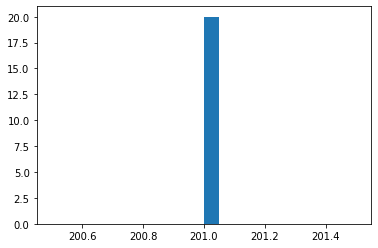

In [71]:
base_gcs_path = 'gs://wildfish_478/train/'

dir_path2 = '/Users/vittoriopro/MSDS/462/FinalProject/Datasets/WildFish/WildFish_Tropical_Split_2_0/train_200'

os.chdir(dir_path2)

data_folders2 = list(listdir_nohidden(dir_path2))

#data_folders2.remove('.DS_Store')

filenames2 = [os.listdir(f) for f in data_folders2]


lenghts2 = [len(f) for f in filenames2]


plt.hist(lenghts2, density=True, bins=20)

files_dict2 = dict(zip(data_folders2, filenames2))

lengh_dict2 = dict(zip(data_folders2,lenghts2))

folders_dict2 = dict(zip(data_folders2, data_folders2))



data_array = []

for (dict_key, files_list) in files_dict2.items():
    for filename in files_list:
        if '.jpg' not in filename: 
            continue # don't include non-photos

        label = dict_key
        
        data_array.append(('TRAIN', base_gcs_path + dict_key + '/' + filename , label))
        
df = pd.DataFrame(data_array)

df.to_csv('all_data_train.csv', index=False, header=False)

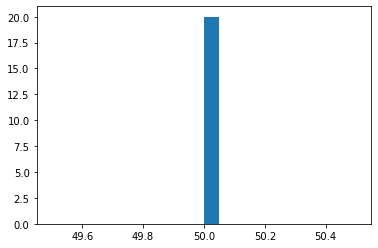

In [72]:
base_gcs_path = 'gs://wildfish_478/test/'

dir_path2 = '/Users/vittoriopro/MSDS/462/FinalProject/Datasets/WildFish/WildFish_Tropical_Split_2_0/test'

os.chdir(dir_path2)

data_folders2 = list(listdir_nohidden(dir_path2))

#data_folders2.remove('.DS_Store')

filenames2 = [os.listdir(f) for f in data_folders2]


lenghts2 = [len(f) for f in filenames2]


plt.hist(lenghts2, density=True, bins=20)

files_dict2 = dict(zip(data_folders2, filenames2))

lengh_dict2 = dict(zip(data_folders2,lenghts2))

folders_dict2 = dict(zip(data_folders2, data_folders2))



data_array = []

for (dict_key, files_list) in files_dict2.items():
    for filename in files_list:
        if '.jpg' not in filename: 
            continue # don't include non-photos

        label = dict_key
        
        data_array.append(('TEST', base_gcs_path + dict_key + '/' + filename , label))
        
df = pd.DataFrame(data_array)

df.to_csv('all_data_test.csv', index=False, header=False)

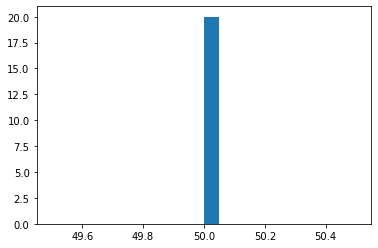

In [73]:
base_gcs_path = 'gs://wildfish_478/val/'

dir_path2 = '/Users/vittoriopro/MSDS/462/FinalProject/Datasets/WildFish/WildFish_Tropical_Split_2_0/val'

os.chdir(dir_path2)

data_folders2 = list(listdir_nohidden(dir_path2))

#data_folders2.remove('.DS_Store')

filenames2 = [os.listdir(f) for f in data_folders2]


lenghts2 = [len(f) for f in filenames2]


plt.hist(lenghts2, density=True, bins=20)

files_dict2 = dict(zip(data_folders2, filenames2))

lengh_dict2 = dict(zip(data_folders2,lenghts2))

folders_dict2 = dict(zip(data_folders2, data_folders2))



data_array = []

for (dict_key, files_list) in files_dict2.items():
    for filename in files_list:
        if '.jpg' not in filename: 
            continue # don't include non-photos

        label = dict_key
        
        data_array.append(('UNASSIGNED', base_gcs_path + dict_key + '/' + filename , label))
        
df = pd.DataFrame(data_array)

df.to_csv('all_data_val.csv', index=False, header=False)

The files obtained need to be merged in a single file called all_data.csv